# NLP assignment

### data loader

In [6]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Added to resolve LookupError

class LegalTextPreprocessor:
    """Preprocessor for legal text data"""

    def __init__(self, max_sequence_length=200, max_vocab_size=20000):
        self.max_sequence_length = max_sequence_length
        self.max_vocab_size = max_vocab_size
        self.stop_words = set(stopwords.words('english'))
        self.vocab = None
        self.word_to_idx = None
        self.idx_to_word = None

    def clean_legal_text(self, text):
        """Clean and preprocess legal text"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits but keep legal terms
        text = re.sub(r'[^a-zA-Z\s\.\,\;\(\)]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_text(self, text):
        """Tokenize text and remove stopwords"""
        tokens = word_tokenize(text)
        # Remove stopwords and short tokens, but keep legal terminology
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 1]
        return tokens

    def build_vocabulary(self, texts):
        """Build vocabulary from all texts"""
        all_tokens = []
        for text in texts:
            cleaned_text = self.clean_legal_text(text)
            tokens = self.tokenize_text(cleaned_text)
            all_tokens.extend(tokens)

        # Count word frequencies
        word_counts = Counter(all_tokens)

        # Get most common words
        most_common = word_counts.most_common(self.max_vocab_size - 2)  # -2 for <PAD> and <UNK>

        # Build vocabulary
        self.vocab = ['<PAD>', '<UNK>'] + [word for word, count in most_common]
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(self.vocab)}

        print(f"Vocabulary built with {len(self.vocab)} words")
        return self.vocab

    def text_to_sequence(self, text):
        """Convert text to sequence of indices"""
        if self.word_to_idx is None:
            raise ValueError("Vocabulary not built. Call build_vocabulary first.")

        cleaned_text = self.clean_legal_text(text)
        tokens = self.tokenize_text(cleaned_text)

        # Convert tokens to indices
        sequence = [self.word_to_idx.get(token, self.word_to_idx['<UNK>']) for token in tokens]

        # Pad or truncate sequence
        if len(sequence) < self.max_sequence_length:
            sequence = sequence + [self.word_to_idx['<PAD>']] * (self.max_sequence_length - len(sequence))
        else:
            sequence = sequence[:self.max_sequence_length]

        return sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
class LegalClauseDataLoader:
    """Data loader for legal clause similarity task with your data format"""

    def __init__(self, data_path):
        self.data_path = data_path
        self.clauses = []
        self.labels = []
        self.category_map = {}

    def load_data(self):
        """Load all CSV files and combine data"""
        if os.path.isfile(self.data_path):
            # Single CSV file
            all_files = [self.data_path]
        else:
            # Directory with multiple CSV files
            all_files = [os.path.join(self.data_path, f) for f in os.listdir(self.data_path) if f.endswith('.csv')]

        print(f"Found {len(all_files)} CSV files")

        for file_path in all_files:
            try:
                df = pd.read_csv(file_path)
                print(f"Loading {file_path}: {len(df)} clauses")

                # Check column names
                print(f"Columns: {df.columns.tolist()}")

                # Assuming columns: 'clause_text' and 'clause_type'
                for _, row in df.iterrows():
                    clause_text = row['clause_text']
                    clause_type = row['clause_type']

                    self.clauses.append(clause_text)
                    self.labels.append(clause_type)
                    self.category_map[clause_type] = self.category_map.get(clause_type, 0) + 1

            except Exception as e:
                print(f"Error loading {file_path}: {e}")

        print(f"Loaded {len(self.clauses)} clauses from {len(set(self.labels))} categories")
        print(f"Category distribution: {self.category_map}")
        return self.clauses, self.labels

    def create_similarity_pairs(self, test_size=0.2, val_size=0.1, max_pairs_per_category=50):
        """Create positive and negative pairs for similarity learning"""
        # Create positive pairs (same category)
        positive_pairs = []
        negative_pairs = []

        # Group clauses by category
        category_groups = {}
        for clause, category in zip(self.clauses, self.labels):
            if category not in category_groups:
                category_groups[category] = []
            category_groups[category].append(clause)

        print("Generating positive pairs...")
        # Generate positive pairs (within same category)
        for category, clauses in category_groups.items():
            if len(clauses) >= 2:
                pair_count = 0
                for i in range(len(clauses)):
                    for j in range(i + 1, min(i + 2, len(clauses))):  # Limit to avoid too many pairs
                        if pair_count < max_pairs_per_category:
                            positive_pairs.append((clauses[i], clauses[j], 1))
                            pair_count += 1

        print("Generating negative pairs...")
        # Generate negative pairs (different categories)
        categories = list(category_groups.keys())
        pair_count = 0

        for i, cat1 in enumerate(categories):
            clauses1 = category_groups[cat1]
            for j, cat2 in enumerate(categories):
                if i != j and pair_count < len(positive_pairs) * 1.2:  # Slightly more negative pairs
                    clauses2 = category_groups[cat2]
                    # Create balanced negative pairs
                    for k in range(min(2, len(clauses1))):
                        for l in range(min(2, len(clauses2))):
                            if pair_count < len(positive_pairs) * 1.2:
                                negative_pairs.append((clauses1[k], clauses2[l], 0))
                                pair_count += 1

        # Combine and shuffle pairs
        all_pairs = positive_pairs + negative_pairs
        np.random.shuffle(all_pairs)

        print(f"Total pairs: {len(all_pairs)} (Positive: {len(positive_pairs)}, Negative: {len(negative_pairs)})")

        # Split data
        pairs_train, pairs_temp = train_test_split(all_pairs, test_size=test_size + val_size, random_state=42)
        pairs_val, pairs_test = train_test_split(pairs_temp, test_size=test_size/(test_size + val_size), random_state=42)

        return pairs_train, pairs_val, pairs_test

### Model Architectures

In [3]:
class BiLSTMAttentionModel:
    """BiLSTM with Attention mechanism for text similarity"""

    def __init__(self, vocab_size, embedding_dim=100, lstm_units=128, max_sequence_length=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_sequence_length = max_sequence_length
        self.model = None

    def build_model(self):
        """Build the BiLSTM with Attention model"""

        # Input layers
        input_a = tf.keras.Input(shape=(self.max_sequence_length,), name='input_a')
        input_b = tf.keras.Input(shape=(self.max_sequence_length,), name='input_b')

        # Shared embedding layer
        embedding_layer = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_sequence_length,
            mask_zero=True,
            name='embedding'
        )

        # Shared BiLSTM layer
        bilstm_layer = layers.Bidirectional(
            layers.LSTM(self.lstm_units, return_sequences=True, dropout=0.2),
            name='bilstm'
        )

        # Attention mechanism
        def attention_layer(inputs):
            attention = layers.Dense(1, activation='tanh')(inputs)
            attention = layers.Flatten()(attention)
            attention = layers.Activation('softmax')(attention)
            attention = layers.RepeatVector(self.lstm_units * 2)(attention)
            attention = layers.Permute([2, 1])(attention)
            weighted_input = layers.Multiply()([inputs, attention])
            return layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_input)

        # Process input A
        embedded_a = embedding_layer(input_a)
        lstm_out_a = bilstm_layer(embedded_a)
        attention_out_a = attention_layer(lstm_out_a)

        # Process input B
        embedded_b = embedding_layer(input_b)
        lstm_out_b = bilstm_layer(embedded_b)
        attention_out_b = attention_layer(lstm_out_b)

        # Similarity computation
        l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([attention_out_a, attention_out_b])
        l2_distance = layers.Lambda(lambda x: tf.square(x[0] - x[1]))([attention_out_a, attention_out_b])

        concatenated = layers.Concatenate()([attention_out_a, attention_out_b, l1_distance, l2_distance])

        # Dense layers
        dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
        dropout1 = layers.Dropout(0.3)(dense1)
        dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
        dropout2 = layers.Dropout(0.3)(dense2)

        # Output layer
        output = layers.Dense(1, activation='sigmoid', name='output')(dropout2)

        # Create model
        self.model = models.Model(inputs=[input_a, input_b], outputs=output)

        # Compile model
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return self.model

class CNNMultiScaleModel:
    """CNN with multiple filter sizes for text similarity"""

    def __init__(self, vocab_size, embedding_dim=100, max_sequence_length=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_sequence_length = max_sequence_length
        self.model = None

    def build_model(self):
        """Build CNN with multiple filter sizes"""

        # Input layers
        input_a = tf.keras.Input(shape=(self.max_sequence_length,), name='input_a')
        input_b = tf.keras.Input(shape=(self.max_sequence_length,), name='input_b')

        # Shared embedding layer
        embedding_layer = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_sequence_length,
            mask_zero=False,
            name='embedding'
        )

        def create_cnn_branch(input_layer):
            embedded = embedding_layer(input_layer)

            # Multiple filter sizes
            conv_blocks = []
            for filter_size in [3, 4, 5]:
                conv = layers.Conv1D(
                    filters=64,
                    kernel_size=filter_size,
                    padding='same',
                    activation='relu'
                )(embedded)
                pool = layers.GlobalMaxPooling1D()(conv)
                conv_blocks.append(pool)

            # Concatenate features from different filter sizes
            concatenated = layers.Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

            # Additional processing
            dense1 = layers.Dense(128, activation='relu')(concatenated)
            dropout1 = layers.Dropout(0.3)(dense1)
            dense2 = layers.Dense(64, activation='relu')(dropout1)

            return dense2

        # Process both inputs
        branch_a = create_cnn_branch(input_a)
        branch_b = create_cnn_branch(input_b)

        # Similarity features
        l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([branch_a, branch_b])
        l2_distance = layers.Lambda(lambda x: tf.square(x[0] - x[1]))([branch_a, branch_b])
        dot_product = layers.Dot(axes=1, normalize=True)([branch_a, branch_b])

        # Combine features
        concatenated = layers.Concatenate()([branch_a, branch_b, l1_distance, l2_distance, dot_product])

        # Classification layers
        dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(concatenated)
        dropout1 = layers.Dropout(0.4)(dense1)
        dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
        dropout2 = layers.Dropout(0.4)(dense2)
        dense3 = layers.Dense(32, activation='relu')(dropout2)

        # Output layer
        output = layers.Dense(1, activation='sigmoid', name='output')(dense3)

        # Create model
        self.model = models.Model(inputs=[input_a, input_b], outputs=output)

        # Compile model
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return self.model

### Training and Evaluation

In [4]:
class ModelTrainer:
    """Handles model training and evaluation"""

    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def prepare_data(self, pairs):
        """Prepare data for training"""
        texts_a = [pair[0] for pair in pairs]
        texts_b = [pair[1] for pair in pairs]
        labels = [pair[2] for pair in pairs]

        return texts_a, texts_b, np.array(labels)

    def train(self, train_pairs, val_pairs, preprocessor, epochs=20, batch_size=32):
        """Train the model"""

        # Prepare data
        train_texts_a, train_texts_b, train_labels = self.prepare_data(train_pairs)
        val_texts_a, val_texts_b, val_labels = self.prepare_data(val_pairs)

        print(f"Training on {len(train_texts_a)} pairs, validating on {len(val_texts_a)} pairs")

        # Convert texts to sequences
        print("Converting training texts to sequences...")
        train_seq_a = np.array([preprocessor.text_to_sequence(text) for text in train_texts_a])
        train_seq_b = np.array([preprocessor.text_to_sequence(text) for text in train_texts_b])

        print("Converting validation texts to sequences...")
        val_seq_a = np.array([preprocessor.text_to_sequence(text) for text in val_texts_a])
        val_seq_b = np.array([preprocessor.text_to_sequence(text) for text in val_texts_b])

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]

        # Train model
        print(f"Starting training for {self.model_name}...")
        self.history = self.model.fit(
            [train_seq_a, train_seq_b],
            train_labels,
            validation_data=([val_seq_a, val_seq_b], val_labels),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self, test_pairs, preprocessor):
        """Evaluate model performance"""

        test_texts_a, test_texts_b, test_labels = self.prepare_data(test_pairs)

        test_seq_a = np.array([preprocessor.text_to_sequence(text) for text in test_texts_a])
        test_seq_b = np.array([preprocessor.text_to_sequence(text) for text in test_texts_b])

        # Predictions
        predictions = self.model.predict([test_seq_a, test_seq_b])
        predicted_probs = predictions.flatten()
        predicted_labels = (predicted_probs > 0.5).astype(int)

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(test_labels, predicted_labels),
            'precision': precision_score(test_labels, predicted_labels, zero_division=0),
            'recall': recall_score(test_labels, predicted_labels, zero_division=0),
            'f1_score': f1_score(test_labels, predicted_labels, zero_division=0),
            'roc_auc': roc_auc_score(test_labels, predicted_probs),
            'pr_auc': average_precision_score(test_labels, predicted_probs)
        }

        return metrics, predicted_probs, test_labels

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss
        ax1.plot(self.history.history['loss'], label='Training Loss')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracy
        ax2.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax2.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        plt.tight_layout()
        plt.show()

### Main Execution Script

=== Legal Clause Similarity Analysis ===
1. Loading data...
Found 1 CSV files
Loading /content/final_file.csv: 150881 clauses
Columns: ['clause_text', 'clause_type']
Loaded 150881 clauses from 395 categories
Category distribution: {'absence-of-certain-changes-or-events': 350, 'absence-of-certain-changes': 350, 'acceleration': 350, 'access-to-information': 270, 'access': 310, 'accounting-terms': 370, 'additional-agreements': 400, 'additional-documents': 470, 'adjustments': 360, 'affirmative-covenants': 500, 'agreement': 500, 'agreements': 480, 'amendment-and-waiver': 400, 'amendment-waiver': 380, 'amendment': 370, 'amendments-and-waivers': 330, 'amendments-etc': 340, 'amendments-waivers': 370, 'amendments': 460, 'applicable-law': 420, 'application-of-proceeds': 420, 'appointment': 360, 'approvals': 410, 'arbitration': 240, 'assignability': 430, 'assignment': 400, 'assignments': 380, 'attorneys-fees': 450, 'authority': 330, 'authorization': 340, 'auto_renewal': 383, 'background': 380, 'b

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'flatten_1' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


5. Training and evaluating models...

--- Training BiLSTM with Attention Model ---
Training on 30355 pairs, validating on 4336 pairs
Converting training texts to sequences...
Converting validation texts to sequences...
Starting training for BiLSTM with Attention...
Epoch 1/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.8533 - loss: 1.0389 - val_accuracy: 0.9899 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 2/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9823 - loss: 0.1090 - val_accuracy: 0.9885 - val_loss: 0.0639 - learning_rate: 0.0010
Epoch 3/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9893 - loss: 0.0680 - val_accuracy: 0.9825 - val_loss: 0.0721 - learning_rate: 0.0010
Epoch 4/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9916 - loss: 0.0585 - val_accuracy: 0.9945 - val_loss: 0.0494 - learning_rate: 0.0010
Epoch 5/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.9912 - loss: 0.0588 - val_accuracy: 0.9719 - val_l

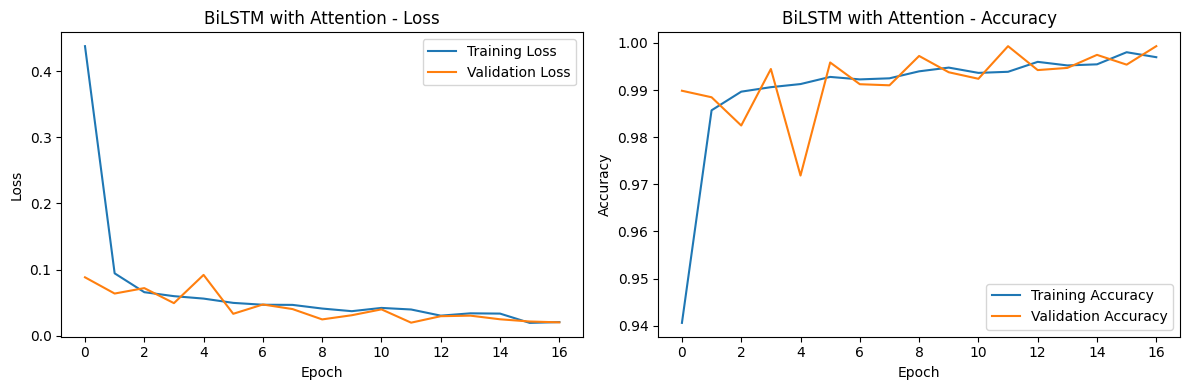


--- Training CNN Multi-Scale Model ---
Training on 30355 pairs, validating on 4336 pairs
Converting training texts to sequences...
Converting validation texts to sequences...
Starting training for CNN Multi-Scale...
Epoch 1/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.8951 - loss: 0.6467 - val_accuracy: 0.9993 - val_loss: 0.0153 - learning_rate: 0.0010
Epoch 2/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9979 - loss: 0.0258 - val_accuracy: 0.9995 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 3/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9975 - loss: 0.0258 - val_accuracy: 0.9993 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 4/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9977 - loss: 0.0320 - val_accuracy: 0.9991 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 5/20
949/949 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9986 - loss: 0.0141 - val_accuracy: 0.9991 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 6/20
949/949 ━━

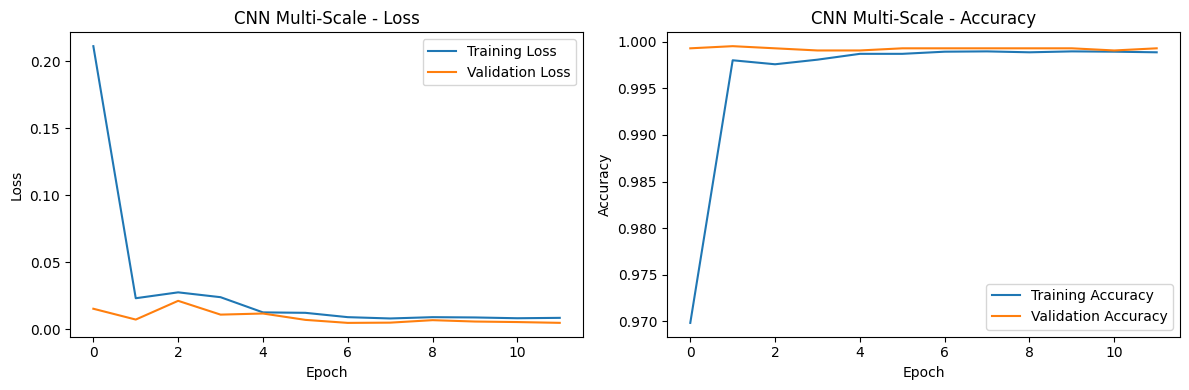


6. Model Comparison:

BiLSTM with Attention Results:
  accuracy: 0.9985
  precision: 1.0000
  recall: 0.9967
  f1_score: 0.9983
  roc_auc: 1.0000
  pr_auc: 1.0000

CNN Multi-Scale Results:
  accuracy: 0.9991
  precision: 1.0000
  recall: 0.9980
  f1_score: 0.9990
  roc_auc: 0.9992
  pr_auc: 0.9995

7. Qualitative Analysis:

Qualitative Results:

BiLSTM Correct Examples (showing 3):

Example 1:
Clause A: Amendment and Waiver. The provisions of this Agreement may be amended or waived only with the prior written consent of the Company (as approved by the...
Clause B: Environmental Laws. The Company and its Subsidiaries (i) are in compliance with any and all Environmental Laws (as hereinafter defined), (ii) have rec...
True Label: 0, BiLSTM Score: 0.000
--------------------------------------------------------------------------------

Example 2:
Clause A: Exclusivity. Throughout the Executive’s employment hereunder, the Executive shall devote substantially all of the Executive’s time, ener

In [7]:
def main():
    """Main execution function"""

    # Configuration
    DATA_PATH = "/content/final_file.csv"  # Update this to your CSV file path
    EMBEDDING_DIM = 100
    MAX_SEQUENCE_LENGTH = 200
    VOCAB_SIZE = 20000
    BATCH_SIZE = 32
    EPOCHS = 20

    print("=== Legal Clause Similarity Analysis ===")

    # Step 1: Load and preprocess data
    print("1. Loading data...")
    data_loader = LegalClauseDataLoader(DATA_PATH)
    clauses, labels = data_loader.load_data()

    # Step 2: Create similarity pairs
    print("2. Creating similarity pairs...")
    train_pairs, val_pairs, test_pairs = data_loader.create_similarity_pairs()

    print(f"Training pairs: {len(train_pairs)}")
    print(f"Validation pairs: {len(val_pairs)}")
    print(f"Test pairs: {len(test_pairs)}")

    # Step 3: Initialize preprocessor and build vocabulary
    print("3. Building vocabulary...")
    preprocessor = LegalTextPreprocessor(MAX_SEQUENCE_LENGTH, VOCAB_SIZE)
    preprocessor.build_vocabulary(clauses)

    # Step 4: Initialize models
    print("4. Initializing models...")

    # Model 1: BiLSTM with Attention
    bilstm_model = BiLSTMAttentionModel(
        vocab_size=len(preprocessor.vocab),
        embedding_dim=EMBEDDING_DIM,
        max_sequence_length=MAX_SEQUENCE_LENGTH
    )
    bilstm_model.build_model()

    # Model 2: CNN Multi-Scale
    cnn_model = CNNMultiScaleModel(
        vocab_size=len(preprocessor.vocab),
        embedding_dim=EMBEDDING_DIM,
        max_sequence_length=MAX_SEQUENCE_LENGTH
    )
    cnn_model.build_model()

    # Step 5: Train and evaluate models
    print("5. Training and evaluating models...")

    # Train BiLSTM model
    print("\n--- Training BiLSTM with Attention Model ---")
    bilstm_trainer = ModelTrainer(bilstm_model.model, "BiLSTM with Attention")
    bilstm_history = bilstm_trainer.train(train_pairs, val_pairs, preprocessor, EPOCHS, BATCH_SIZE)
    bilstm_metrics, bilstm_probs, bilstm_true = bilstm_trainer.evaluate(test_pairs, preprocessor)
    bilstm_trainer.plot_training_history()

    # Train CNN model
    print("\n--- Training CNN Multi-Scale Model ---")
    cnn_trainer = ModelTrainer(cnn_model.model, "CNN Multi-Scale")
    cnn_history = cnn_trainer.train(train_pairs, val_pairs, preprocessor, EPOCHS, BATCH_SIZE)
    cnn_metrics, cnn_probs, cnn_true = cnn_trainer.evaluate(test_pairs, preprocessor)
    cnn_trainer.plot_training_history()

    # Step 6: Compare results
    print("\n6. Model Comparison:")
    print("\nBiLSTM with Attention Results:")
    for metric, value in bilstm_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print("\nCNN Multi-Scale Results:")
    for metric, value in cnn_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Step 7: Show qualitative examples
    print("\n7. Qualitative Analysis:")
    show_qualitative_results(test_pairs, bilstm_probs, cnn_probs, n_examples=5)

    return {
        'bilstm': bilstm_metrics,
        'cnn': cnn_metrics,
        'preprocessor': preprocessor,
        'test_pairs': test_pairs
    }

def show_qualitative_results(test_pairs, bilstm_probs, cnn_probs, n_examples=5):
    """Show examples of correct and incorrect predictions"""

    test_texts_a, test_texts_b, test_labels = [], [], []
    for pair in test_pairs:
        test_texts_a.append(pair[0])
        test_texts_b.append(pair[1])
        test_labels.append(pair[2])

    print("\nQualitative Results:")
    print("=" * 100)

    # Find some examples
    correct_bilstm = []
    incorrect_bilstm = []

    for i in range(min(100, len(test_labels))):  # Check first 100 examples
        bilstm_pred = 1 if bilstm_probs[i] > 0.5 else 0
        cnn_pred = 1 if cnn_probs[i] > 0.5 else 0

        if bilstm_pred == test_labels[i]:
            correct_bilstm.append(i)
        else:
            incorrect_bilstm.append(i)

    # Show examples
    print(f"\nBiLSTM Correct Examples (showing {min(3, len(correct_bilstm))}):")
    for idx, i in enumerate(correct_bilstm[:3]):
        print(f"\nExample {idx + 1}:")
        print(f"Clause A: {test_texts_a[i][:150]}...")
        print(f"Clause B: {test_texts_b[i][:150]}...")
        print(f"True Label: {test_labels[i]}, BiLSTM Score: {bilstm_probs[i]:.3f}")
        print("-" * 80)

    print(f"\nBiLSTM Incorrect Examples (showing {min(2, len(incorrect_bilstm))}):")
    for idx, i in enumerate(incorrect_bilstm[:2]):
        print(f"\nExample {idx + 1}:")
        print(f"Clause A: {test_texts_a[i][:150]}...")
        print(f"Clause B: {test_texts_b[i][:150]}...")
        print(f"True Label: {test_labels[i]}, BiLSTM Score: {bilstm_probs[i]:.3f}")
        print("-" * 80)

if __name__ == "__main__":
    results = main()